In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0

plt.style.use('ggplot')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
path = "/kaggle/input/binary-classification-data-aptos-and-messidor/Train Images_new"
folders = os.listdir(path)
folder_path = os.path.join(path, folders[0])

files = os.listdir(folder_path)
files = files[1:]

Images = []
Labels = []

for i in range(len(files)):
    file_path = os.path.join(folder_path, files[i])
    
    for img in os.listdir(file_path):
        image_path = os.path.join(file_path ,img)
            
        Images.append(image_path)
        if file_path.split('_')[-1] == '0':
            Labels.append(0)  # Use 0 for class 0
        else:
            Labels.append(1)  # Use 1 for class 1

df = pd.DataFrame({'Images': Images, 'Labels': Labels})
df.head()

,Images,Labels
0,/kaggle/input/binary-classification-data-aptos...,1
1,/kaggle/input/binary-classification-data-aptos...,1
2,/kaggle/input/binary-classification-data-aptos...,1
3,/kaggle/input/binary-classification-data-aptos...,1
4,/kaggle/input/binary-classification-data-aptos...,1


In [3]:
df['Labels'].value_counts()

Labels
1    7425
0    7220
Name: count, dtype: int64

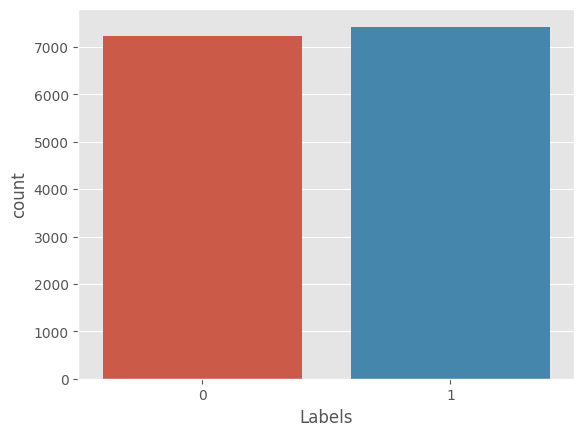

In [4]:
sns.countplot(data=df, x='Labels')
plt.show()

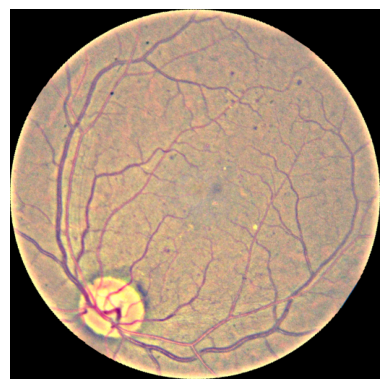

In [5]:
random_image_path = random.choice(df['Images'])
image = Image.open(random_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

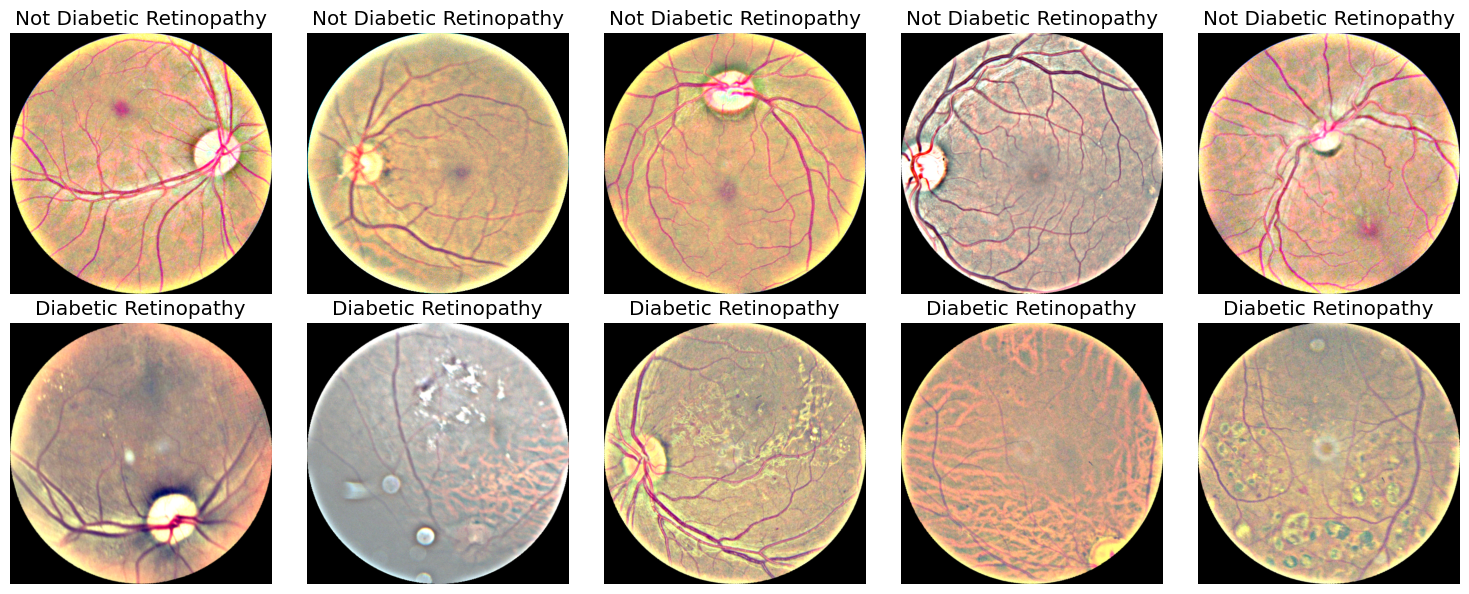

In [6]:
class_0_path = df[df['Labels'] == 0].reset_index(drop=True)
class_1_path = df[df['Labels'] == 1].reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < 5:
        image_path = random.choice(class_0_path['Images'])
        ax.set_title("Not Diabetic Retinopathy")
    else:
        image_path = random.choice(class_1_path['Images'])
        ax.set_title("Diabetic Retinopathy")

    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')  

plt.tight_layout()
plt.show()

In [7]:
img_size = (224, 224)
batch_size = 32


In [8]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [9]:
class RetinaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
train_df, validation_df = train_test_split(df, random_state=42, test_size=0.1, shuffle=True)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [11]:
train_dataset = RetinaDataset(train_df, transform=transform)
val_dataset = RetinaDataset(validation_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
model = efficientnet_b0(weights='IMAGENET1K_V1')  # Use pre-trained EfficientNetB0
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Modify for 2 classes
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [16]:
# Training loop
num_epochs = 20
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
    
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)
    
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct.double() / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    train_acc_list.append(train_acc.item())
    val_acc_list.append(val_acc.item())
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

Epoch 1/20, Train Loss: 0.0769, Train Acc: 0.9757, Val Loss: 0.0324, Val Acc: 0.9911
Epoch 2/20, Train Loss: 0.0299, Train Acc: 0.9901, Val Loss: 0.0252, Val Acc: 0.9918
Epoch 3/20, Train Loss: 0.0183, Train Acc: 0.9936, Val Loss: 0.0332, Val Acc: 0.9911
Epoch 4/20, Train Loss: 0.0132, Train Acc: 0.9958, Val Loss: 0.0348, Val Acc: 0.9891
Epoch 5/20, Train Loss: 0.0107, Train Acc: 0.9970, Val Loss: 0.0209, Val Acc: 0.9952
Epoch 6/20, Train Loss: 0.0142, Train Acc: 0.9957, Val Loss: 0.0316, Val Acc: 0.9925
Epoch 7/20, Train Loss: 0.0113, Train Acc: 0.9958, Val Loss: 0.0202, Val Acc: 0.9939
Epoch 8/20, Train Loss: 0.0057, Train Acc: 0.9981, Val Loss: 0.0253, Val Acc: 0.9925
Epoch 9/20, Train Loss: 0.0045, Train Acc: 0.9984, Val Loss: 0.0157, Val Acc: 0.9952
Epoch 10/20, Train Loss: 0.0077, Train Acc: 0.9969, Val Loss: 0.0195, Val Acc: 0.9966
Epoch 11/20, Train Loss: 0.0116, Train Acc: 0.9962, Val Loss: 0.0148, Val Acc: 0.9973
Epoch 12/20, Train Loss: 0.0047, Train Acc: 0.9988, Val Loss: 0

In [17]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_36/869501355.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [18]:
model.eval()
val_loss, val_correct = 0, 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)

val_loss /= len(val_loader.dataset)
val_acc = val_correct.double() / len(val_loader.dataset)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

Validation Loss: 0.0074, Validation Accuracy: 0.9986


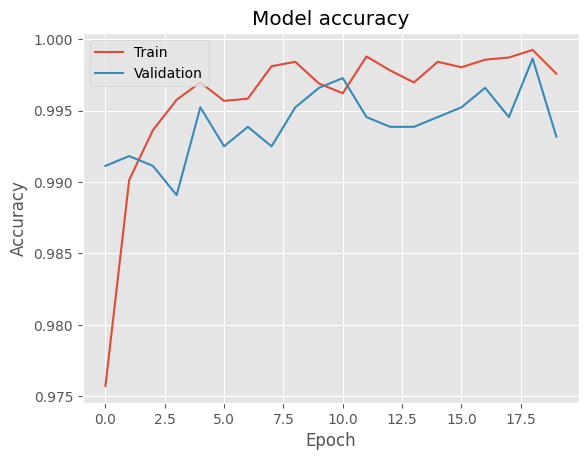

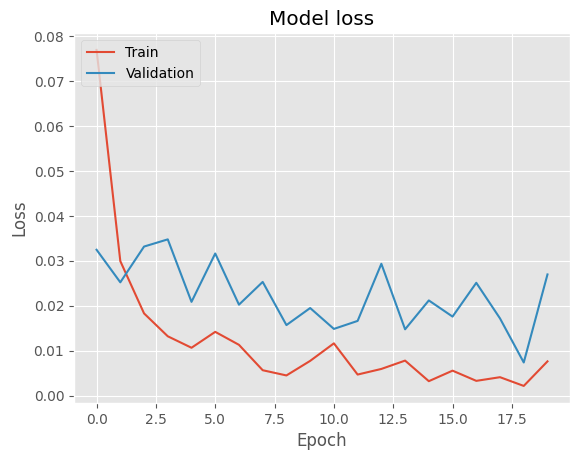

In [19]:
# Plot training & validation accuracy values
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()